# calculate the reference values for the 4 outputs

In [1]:
import numpy as np
from glob import glob
from skimage.morphology import skeletonize_3d
from medutils.medutils import load_itk, save_itk
import SimpleITK as sitk
import itk
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.morphology import disk,diamond,rectangle,square,erosion,dilation,opening,closing,skeletonize
import pickle
import pandas as pd
import json
import matplotlib
import copy
import pingouin as pg

from scipy.stats import pearsonr


/home/jjia/.local/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/jjia/.local/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
file_fpath = 'all_biomarkers_correct3.csv'
df=pd.read_csv(file_fpath)

In [52]:
mode = 'valid'  # valid or test
net_pred_fpath1 = f"/home/jjia/data/lung_function/lung_function/scripts/results/experiments/2663/{mode}_pred.csv"
net_pred_fpath2 = f"/home/jjia/data/lung_function/lung_function/scripts/results/experiments/2654/{mode}_pred.csv"
net_pred_fpath3 = f"/home/jjia/data/lung_function/lung_function/scripts/results/experiments/2655/{mode}_pred.csv"
net_pred_fpath4 = f"/home/jjia/data/lung_function/lung_function/scripts/results/experiments/2661/{mode}_pred.csv"

net_label_fpath = f"/home/jjia/data/lung_function/lung_function/scripts/results/experiments/2663/{mode}_label.csv"

df_net_pred1 = pd.read_csv(net_pred_fpath1)
df_net_pred2 = pd.read_csv(net_pred_fpath2)
df_net_pred3 = pd.read_csv(net_pred_fpath3)
df_net_pred4 = pd.read_csv(net_pred_fpath4)
df_net_pred = pd.DataFrame({'pat_id': df_net_pred1['pat_id'],'DLCOc':df_net_pred1['DLCOc_SB'], 'FEV1': df_net_pred2['FEV1'], 'FVC': df_net_pred3['FVC'],'TLC': df_net_pred4['TLC_He'] })
df_net_label = pd.read_csv(net_label_fpath)

In [53]:
df_net_pred

,pat_id,DLCOc,FEV1,FVC,TLC
0,127512,3.328,1.783,2.777,3.457
1,139552,4.387,2.268,3.395,5.656
2,143788,4.203,2.186,2.865,3.650
3,265042,5.992,3.344,4.180,4.562
4,320142,4.137,2.320,2.986,3.625
...,...,...,...,...,...
248,7582492,6.530,2.834,3.895,4.273
249,7584898,6.720,3.564,3.795,4.016
250,7628640,6.550,2.738,3.342,4.223
251,7694688,3.822,1.678,1.794,3.057


In [54]:
# remove one patient without the % predicted values because of the insuffient technique
pat_id_wo_pred = 8334199
pat_id_wo_pred2 = 315457
pat_id_wo_pred_ls = [8334199, 315457]
pat_id_unknownerror_ls = [422335, 4036570]

pat_id_rm_ls = pat_id_wo_pred_ls + pat_id_wo_pred_ls
for i in pat_id_rm_ls:
    df_net_pred = df_net_pred[df_net_pred['pat_id']!=i]

    df_net_label = df_net_label[df_net_label['pat_id']!=i]

    df_label = df_label[df_label['PatID']!=i]


In [55]:
# extract testing dataset form the whole dataset
first_ts_pat_id = 7957098
if mode=='test':
    df_label = df.loc[df['PatID'] >= first_ts_pat_id]
else:
    df_label = df.loc[df['PatID'] < first_ts_pat_id]


In [56]:
df_net_pred = df_net_pred.sort_values(by='pat_id')
df_net_label = df_net_label.sort_values(by='pat_id')

df_net_label


,pat_id,DLCOc_SB
190,68800,7.102
0,127512,3.943
1,139552,5.273
2,143788,1.240
127,152440,7.102
...,...,...
251,7694688,5.830
125,7740702,3.052
189,7794304,6.100
252,7852072,4.820


In [65]:
df_net_pred = df_net_pred.rename(columns={'DLCOc_SB':'DLCOc', 'TLC_He': 'TLC', 'pat_id': 'PatID', 'DLCO_SB': 'DLCOc'})
df_net_label = df_net_label.rename(columns={'DLCOc_SB':'DLCOc', 'TLC_He': 'TLC', 'pat_id': 'PatID', 'DLCO_SB': 'DLCOc'})

df_label = df_label.sort_values('PatID').set_axis(range(len(df_label)))
df_net_pred = df_net_pred.sort_values('PatID').set_axis(range(len(df_net_pred)))
df_net_label = df_net_label.sort_values('PatID').set_axis(range(len(df_net_label)))
df_net_pred.columns

Index(['PatID', 'DLCOc', 'FEV1', 'FVC', 'TLC'], dtype='object')

In [66]:
# 设置显示选项以避免省略 DataFrame 的元素
pd.set_option('display.max_columns', None)  # 显示所有列
pd.set_option('display.max_rows', None)  # 显示所有行
pd.set_option('display.expand_frame_repr', False)  # 当行太长时不换行显示
df_net_label

,PatID,DLCOc
0,68800,7.102
1,127512,3.943
2,139552,5.273
3,143788,1.240
4,152440,7.102
5,163750,6.444
6,213786,1.995
7,219312,11.284
8,222357,3.034
9,234084,3.799


In [59]:
for i in zip(df_label['DLCOc'], df_net_label['DLCOc'], df_net_pred['DLCOc']):
    print(i)

(7.102, 7.102, 7.906)
(3.943, 3.943, 3.328)
(5.273, 5.273, 4.387)
(1.24, 1.24, 4.203)
(7.102, 7.102, 6.105)
(6.444, 6.444, 4.16)
(1.995, 1.995, 5.23)
(11.284, 11.284, 10.28)
(3.034, 3.034, 3.521)
(3.799, 3.799, 5.53)
(4.965, 4.965, 6.44)
(7.525, 7.525, 5.992)
(7.439, 7.439, 7.516)
(6.568, 6.568, 7.71)
(5.406, 5.406, 4.34)
(6.55, 6.55, 6.793)
(4.248, 4.248, 4.137)
(4.079, 4.079, 4.0)
(3.07, 3.07, 2.936)
(7.528, 7.528, 4.64)
(4.521, 2.911, 3.39)
(2.911, 7.183, 8.125)
(7.183, 5.92, 5.43)
(5.92, 6.57, 5.94)
(6.57, 6.733, 4.715)
(6.733, 4.902, 6.543)
(4.902, 4.336, 4.02)
(4.336, 9.153, 8.69)
(9.153, 4.618, 6.426)
(4.618, 3.861, 4.81)
(3.861, 2.223, 3.828)
(2.223, 7.21, 4.76)
(7.21, 5.994, 5.67)
(5.994, 7.427, 8.805)
(7.427, 6.302, 6.844)
(6.302, 3.781, 5.914)
(3.781, 4.07, 5.65)
(4.07, 7.05, 6.69)
(7.05, 6.189, 4.266)
(6.189, 7.603, 7.727)
(7.603, 4.666, 5.92)
(4.666, 7.832, 9.07)
(7.832, 3.054, 3.87)
(3.054, 6.468, 6.113)
(6.468, 7.11, 5.31)
(7.11, 7.55, 7.01)
(7.55, 3.147, 3.172)
(3.147, 

In [36]:
# icc
def icc(label, pred, columns = []):
    label['ID'] = np.arange(1, len(label) + 1)
    label['rater'] = 'label'

    pred['ID'] = np.arange(1, len(pred) + 1)
    pred['rater'] = 'pred'

    data = pd.concat([label, pred], axis=0)

    for column in columns:
        icc = pg.intraclass_corr(data=data, targets='ID', raters='rater', ratings=column).round(2)
        icc = icc.set_index("Type")
        icc = icc.loc['ICC2']['ICC']
        print(f"icc for {column}: {icc}")
    return icc
        # prefix = label_fpath.split("/")[-1].split("_")[0]
        # icc_dict['icc_' + prefix + '_' + column] = icc

In [37]:
icc_value = icc(df_net_label, df_net_pred,columns=['DLCOc', 'FEV1', 'FVC', 'TLC'])  #['DLCOc', 'FEV1', 'FVC', 'TLC']


icc for DLCOc: 0.7


AssertionError: 

In [212]:
for column in ['DLCOc', 'FEV1', 'FVC', 'TLC']:
    df_net_ts_pred[column+'PP'] = df_net_ts_pred[column] / test_df[column+"Ref"] * 100

In [213]:
df_net_ts_pred

,pat_id,FVC,DLCOc,FEV1,TLC,ID,rater,DLCOcPP,FEV1PP,FVCPP,TLCPP
0,7957098,4.25550,7.34800,3.44750,6.01450,1,pred,94.194894,110.016506,109.307025,101.140695
1,7977032,3.77475,5.96900,2.99250,5.69450,2,pred,85.719440,117.144128,115.631582,108.234503
2,8077626,4.13225,6.66900,3.24325,5.95100,3,pred,89.607399,115.957132,116.864841,107.282078
3,8160998,4.38525,7.50250,3.57775,6.41300,4,pred,98.958232,123.070622,118.841463,115.040134
4,8189796,3.99225,7.07025,3.25300,5.63675,5,pred,90.695529,112.599087,108.533702,93.232876
...,...,...,...,...,...,...,...,...,...,...,...
57,9523013,3.76600,6.35675,3.08925,5.30750,58,pred,56.579884,72.542526,73.179500,67.183544
58,9662556,4.07275,7.83375,3.53825,5.65700,59,pred,93.273164,98.445581,95.719009,98.136083
59,9861781,3.51900,5.76400,2.84600,5.28175,60,pred,59.997026,73.540052,71.816327,74.220670
60,9934096,3.40000,5.37025,2.66000,5.12375,61,pred,88.385365,128.021390,128.159645,110.742296


In [214]:
test_df_slim = test_df[['PatID','rater','DLCOc', 'FEV1', 'FVC', 'TLC','DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP' ]]

In [215]:
test_df_slim

,PatID,rater,DLCOc,FEV1,FVC,TLC,DLCOcPP,FEV1PP,FVCPP,TLCPP
0,7957098,label,9.205,3.635,4.555,5.352,118.0,116.0,117.0,90.0
1,7977032,label,5.710,2.810,3.950,5.840,82.0,110.0,121.0,111.0
2,8077626,label,5.433,2.741,3.642,5.658,73.0,98.0,103.0,102.0
3,8160998,label,4.094,2.878,4.059,6.578,54.0,99.0,110.0,118.0
4,8189796,label,5.301,2.629,3.568,5.139,68.0,91.0,97.0,85.0
...,...,...,...,...,...,...,...,...,...,...
57,9523013,label,6.741,3.492,4.117,5.214,60.0,82.0,80.0,66.0
58,9662556,label,6.551,3.666,4.340,5.188,78.0,102.0,102.0,90.0
59,9861781,label,5.380,3.870,4.900,6.120,56.0,100.0,100.0,86.0
60,9934096,label,4.800,2.057,2.706,4.673,79.0,99.0,102.0,101.0


In [216]:
icc_value = icc(test_df, df_net_ts_pred,columns=['DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP'])


icc for DLCOcPP: 0.52
icc for FEV1PP: 0.44
icc for FVCPP: 0.62
icc for TLCPP: 0.71


In [ ]:
plt.figure()


In [217]:
# show the r between net output and pft absolute values
for colname in ['DLCOc', 'FEV1', 'FVC', 'TLC']:
    corr, p_value = pearsonr(df_net_ts_pred[colname], test_df[colname])
    mean = (df_net_ts_pred[colname] - test_df[colname]).mean()
    std = (df_net_ts_pred[colname] - test_df[colname]).std()
    print(f"{colname}:\t r: {corr:.3f}, mean: {mean:.2f}, std, {std:.2f}")
    


DLCOc:	 r: 0.755, mean: 0.08, std, 1.40
FEV1:	 r: 0.767, mean: 0.17, std, 0.55
FVC:	 r: 0.814, mean: 0.04, std, 0.63
TLC:	 r: 0.828, mean: 0.00, std, 0.83


In [218]:
assert len(df_net_ts_pred) == len(test_df)
df_net_ts_pred = df_net_ts_pred.set_axis(range(len(df_net_ts_pred)))
test_df = test_df.set_axis(range(len(test_df)))

In [219]:
# show the r between net output and pft absolute values
for colname in ['DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP']:
    corr, p_value = pearsonr(df_net_ts_pred[colname], test_df[colname])
    mean = (df_net_ts_pred[colname] - test_df[colname]).mean()
    std = (df_net_ts_pred[colname] - test_df[colname]).std()
    print(f"{colname}:\t r: {corr:.3f}, mean: {mean:.2f}, std, {std:.2f}")
    


DLCOcPP:	 r: 0.522, mean: 2.30, std, 17.28
FEV1PP:	 r: 0.511, mean: 7.69, std, 17.60
FVCPP:	 r: 0.654, mean: 2.59, std, 15.48
TLCPP:	 r: 0.722, mean: 0.44, std, 13.28


In [139]:
df_net_ts_pred

,pat_id,FVC,DLCOc,FEV1,TLC,ID,rater,DLCOcPP,FEV1PP,FVCPP,TLCPP
0,7957098,2.846,4.684,2.490,4.113,1,pred,78.766816,41.872197,47.858744,69.164798
1,7977032,3.137,5.310,2.748,4.566,2,pred,100.926370,52.230822,59.624486,86.785274
2,8077626,3.025,5.414,2.592,4.430,3,pred,97.601273,46.727466,54.533404,79.862142
3,8160998,4.027,7.156,3.572,5.700,4,pred,128.368501,64.076619,72.238674,102.249924
4,8189796,2.988,5.016,2.627,4.336,5,pred,82.965558,43.451061,49.422067,71.718233
...,...,...,...,...,...,...,...,...,...,...,...
57,9523013,3.793,6.570,3.393,5.480,58,pred,83.164557,42.949367,48.012658,69.367089
58,9662556,4.030,7.100,3.695,5.800,59,pred,123.168851,64.099846,69.911334,100.616808
59,9861781,3.783,6.690,3.414,5.387,60,pred,94.009804,47.974510,53.159804,75.699673
60,9934096,2.600,4.496,2.139,3.855,61,pred,97.174406,46.231329,56.195164,83.320137


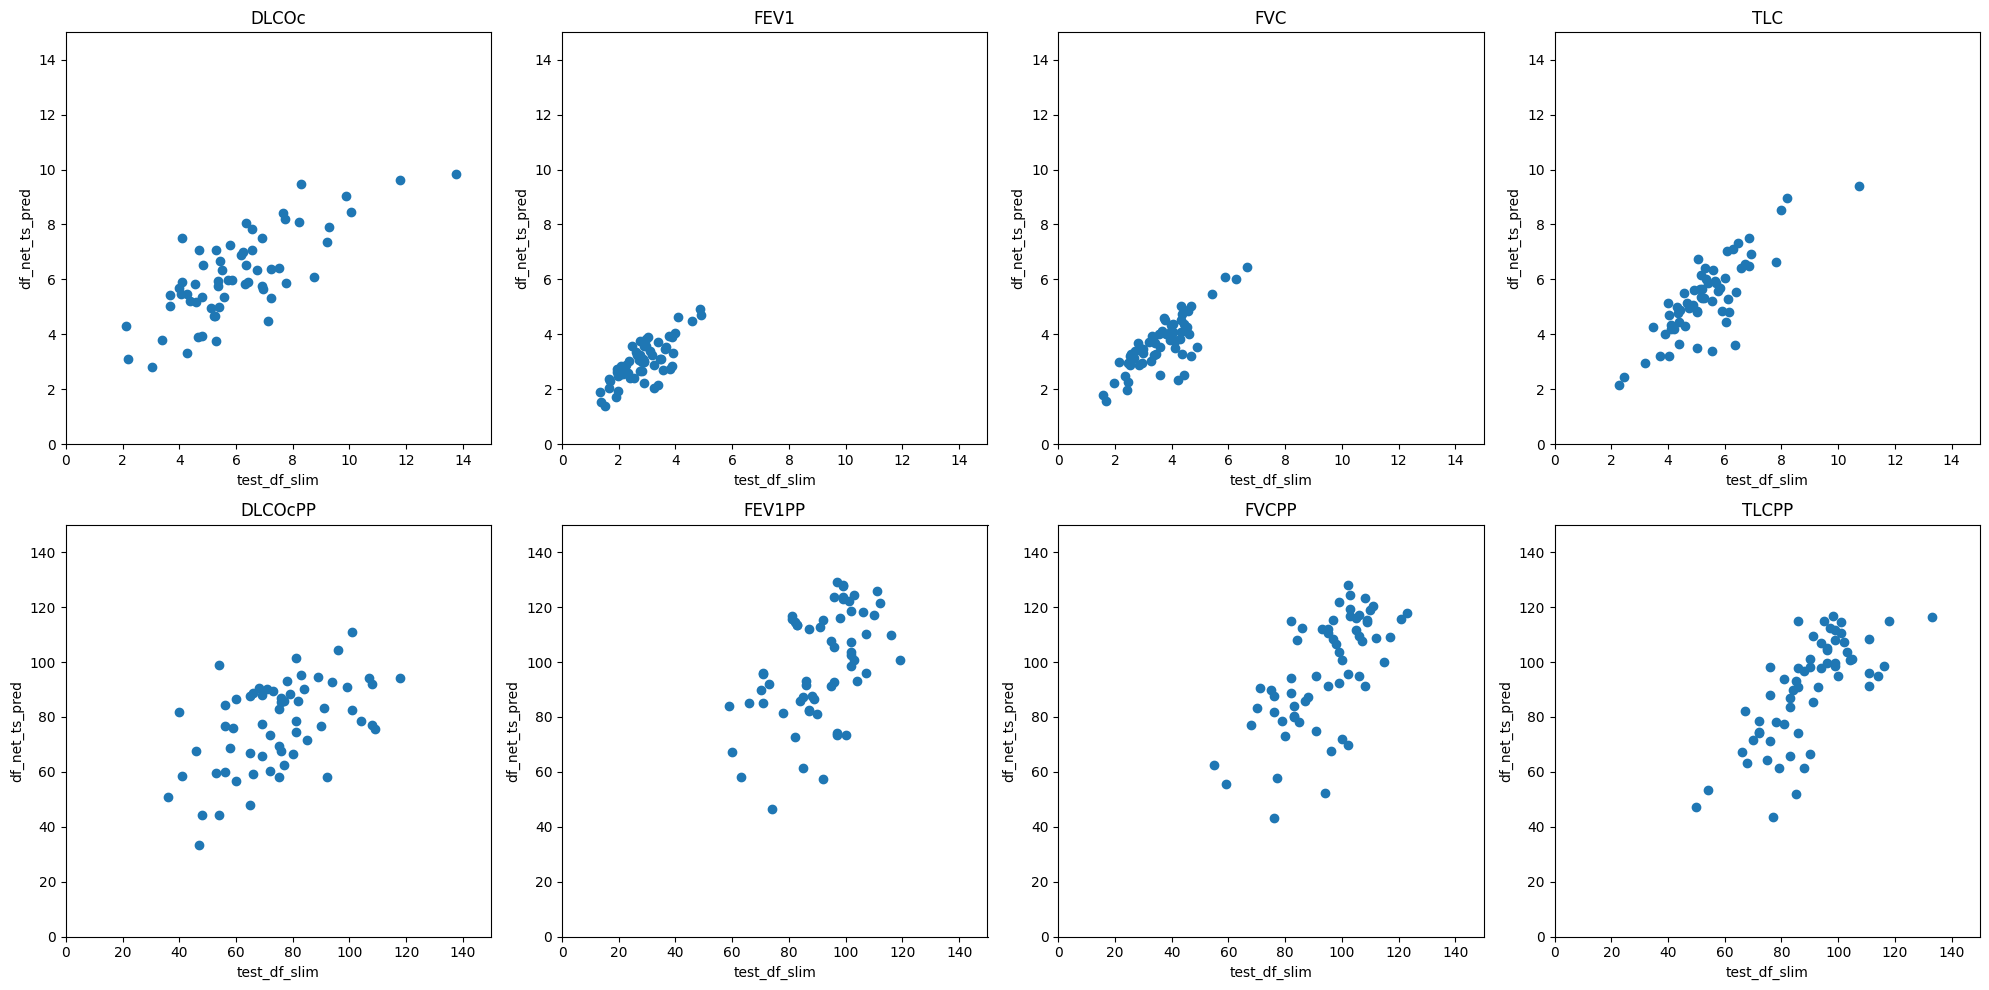

In [220]:
import matplotlib.pyplot as plt

# 列名列表
cols = ['DLCOc', 'FEV1', 'FVC', 'TLC','DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP']

# 创建一个 2 行 4 列的子图
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# 循环遍历每个列
for i, name in enumerate(cols):
    # 计算子图的行和列
    row = i // 4
    col = i % 4
    
    # 绘制散点图
    axs[row, col].scatter(test_df_slim[name], df_net_ts_pred[name])
    
    # 设置子图标题和坐标轴标签
    axs[row, col].set_title(name)
    axs[row, col].set_xlabel('test_df_slim')
    axs[row, col].set_ylabel('df_net_ts_pred')
    if row!=1:
        axs[row, col].set_ylim(0, 15)
        axs[row, col].set_xlim(0, 15)
    else:
        axs[row, col].set_ylim(0, 150)
        axs[row, col].set_xlim(0, 150)
    
# 调整子图之间的间距和边距
plt.tight_layout()

# 显示图像
plt.show()


In [159]:
df_net_ts_pred['FEV1'] / test_df_slim['FEV1PP']*100

0     2.146552
1     2.498182
2     2.644898
3     3.608081
4     2.886813
        ...   
57    4.137805
58    3.622549
59    3.414000
60    2.160606
61    2.306061
Length: 62, dtype: float64

In [198]:
MAPE_FEV1 = ((df_net_ts_pred['FEV1'] - test_df_slim['FEV1']).abs()/test_df_slim['FEV1']).sum()

In [175]:
(df_net_ts_pred['FEV1'] - test_df_slim['FEV1']).abs()

0     1.145
1     0.062
2     0.149
3     0.694
4     0.002
      ...  
57    0.099
58    0.029
59    0.456
60    0.082
61    0.643
Name: FEV1, Length: 62, dtype: float64

In [176]:
test_df_slim['FEV1']

0     3.635
1     2.810
2     2.741
3     2.878
4     2.629
      ...  
57    3.492
58    3.666
59    3.870
60    2.057
61    1.640
Name: FEV1, Length: 62, dtype: float64

In [199]:
MAPE_FEV1PP = ((df_net_ts_pred['FEV1PP'] - test_df_slim['FEV1PP']).abs()/test_df_slim['FEV1PP']).sum()